# PCB Defect Image Extraction

### Install tetryonai

In [ ]:
!pip install git+https://github.com/sean-mcclure/tetryon_ai.git

In [2]:
from tetryonai.main import *

###Make the following folders:

*   difference_img
*   extracted_defects
*   hold_out 

In [3]:
directory(**{
    "choice" : "make",
    "directory_path" : "difference_img"
})

directory(**{
    "choice" : "make",
    "directory_path" : "extracted_defects"
})

directory(**{
    "choice" : "make",
    "directory_path" : "hold_out"
})

###Clone PCB Dataset

In [4]:
!git clone https://github.com/tangsanli5201/DeepPCB.git

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4753 (delta 13), reused 12 (delta 12), pack-reused 4739
Receiving objects: 100% (4753/4753), 85.81 MiB | 15.65 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Checking out files: 100% (4548/4548), done.


### Read in PCB Defect Images (temp and test)

In [5]:
import glob

image_path = 'DeepPCB/PCBData/'
temp_pattern = '/*temp.jpg'
test_pattern = '/*test.jpg'

temps_and_tests = {}

for folder in os.listdir(image_path):
    full_path = image_path + folder + '/' + folder.replace('group', '')
    temps = glob.glob(full_path + '/' + temp_pattern)
    tests = glob.glob(full_path + '/' + test_pattern)
    inner = {}
    inner['temps'] = temps
    inner['tests'] = tests
    temps_and_tests[folder] = inner

### Create Hold Out Dataset with 20% test/temp images, and difference the rest

In [6]:
split_percentage = round(len(temps_and_tests['group00041']['temps']) * 0.2)

for index, whatever in enumerate(temps_and_tests['group00041']['temps']):
    root_img_name = temps_and_tests['group00041']['temps'][index].replace('_temp.jpg', '')
    temp_file_path = root_img_name  + '_temp.jpg'
    test_file_path = root_img_name + '_test.jpg'
    if(index < split_percentage):
      copy_files(**{
          "file_paths" : [temp_file_path],
          "target_directory" : "hold_out/"
      })
      copy_files(**{
          "file_paths" : [test_file_path],
          "target_directory" : "hold_out/"
      })
    else:
      subtract_images(**{
          "image_path_1" : temp_file_path,
          "image_path_2" : test_file_path,
          "write_path" : "difference_img/diff_image_" + str(index) + ".png"
      })

### Extract the defects from all differenced images

In [7]:
all_differenced_images = os.listdir('difference_img')

In [8]:
for index, filename in enumerate(all_differenced_images):
    os.mkdir("extracted_defects/extracts_" + str(index))
    this_write_path = "extracted_defects/extracts_" + str(index) + "/"
    extract_contours_from_image(**{
        "image_path" : "difference_img/" + filename,
        "write_path" : this_write_path,
        "hsv_lower" : [0,150,50],
        "hsv_upper" : [10,255,255]
    })

skipping image difference_img/diff_image_79.png
skipping image difference_img/diff_image_79.png
skipping image difference_img/diff_image_70.png
skipping image difference_img/diff_image_70.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_148.png
skipping image difference_img/diff_image_135.png
skipping image difference_img/diff_image_135.png
skipping image difference_img/diff_image_135.png
skipping image difference_img/diff_image_129.png
skipping image difference_img/diff_image_129.png
skipping image difference_img/diff_image_129.png
skipping image differenc

### Combine extracted images into single directory

In [9]:
directory(**{
    "choice" : "make",
    "directory_path" : "all_extracts"
})

In [10]:
cnt=0
for dirpath, dirs, files in os.walk("extracted_defects"):
    for index, filename in enumerate(files):
        if filename.endswith(".png"):
            cnt += 1            
            move_files(**{
                "file_paths" : [dirpath + "/" + filename],
                "target_directory" : "all_extracts/extract_" + str(cnt) + ".png"
            })

### Zip all extracted defect images 
#### Use for labelling in Defect Turker

In [ ]:
!zip -r /content/extracted_defects.zip /content/all_extracts/

### Create JSON file for defect turker

In [12]:
import json

file_names_and_sizes = {}
file_names = os.listdir('all_extracts/')

for index, file in enumerate(file_names):
  file_names_and_sizes[file_names[index]] = os.path.getsize('all_extracts/' + file)

### Remove any image paths with sizes 0
#### Already taken care of by using tetryonai's contour function, but keeping here for others to use if needed

In [13]:
file_names_and_sizes = {k: v for k, v in file_names_and_sizes.items() if v != 0}

### Save JSON to Disk for Uploading to Defect Turker

In [14]:
with open('extracted_defects.json', 'w') as outfile:
    json.dump(file_names_and_sizes, outfile)

# PCB Defect Classification

##Install FASTAI

In [ ]:
!pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install fastai

In [16]:
from fastai.vision import *

### Upload labelled data (CSV file)

In [ ]:
from google.colab import files
files.upload()

### Convert labelled data CSV to dataframe

In [17]:
!git clone https://github.com/sean-mcclure/defect_classifier.git

Cloning into 'defect_classifier'...
remote: Enumerating objects: 913, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 913 (delta 40), reused 88 (delta 26), pack-reused 806
Receiving objects: 100% (913/913), 247.23 MiB | 19.52 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [18]:
import shutil
shutil.move("/content/defect_classifier/csv/image_labels.csv","/content")

'/content/image_labels.csv'

In [19]:
labels_new = pd.read_csv("image_labels.csv")

In [20]:
l =os.listdir("/content/all_extracts")

In [48]:
m=labels_new.name.values

In [56]:
j=0
lst=[]
for k,i in enumerate(m):
    if i in l:
         j+=1
         lst.append(k)
         print(i)

print(j)

extract_1158.png
extract_866.png
extract_688.png
extract_15.png
extract_622.png
extract_410.png
extract_338.png
extract_1141.png
extract_1205.png
extract_590.png
extract_575.png
extract_703.png
extract_478.png
extract_1250.png
extract_582.png
extract_678.png
extract_700.png
extract_864.png
extract_1160.png
extract_30.png
extract_50.png
extract_996.png
extract_1214.png
extract_482.png
extract_1324.png
extract_1284.png
extract_695.png
extract_328.png
extract_159.png
extract_95.png
extract_42.png
extract_1206.png
extract_815.png
extract_504.png
extract_593.png
extract_402.png
extract_214.png
extract_505.png
extract_340.png
extract_539.png
extract_1254.png
extract_951.png
extract_1026.png
extract_206.png
extract_40.png
extract_727.png
extract_1066.png
extract_259.png
extract_1090.png
extract_780.png
extract_1308.png
extract_374.png
extract_768.png
extract_955.png
extract_146.png
extract_130.png
extract_2.png
extract_87.png
extract_1019.png
extract_9.png
extract_469.png
extract_843.png
extr

In [57]:
labels_new2=labels_new.iloc[lst]

In [58]:
labels_new2.to_csv("/content/image_labels2.csv")

In [59]:
image_labels_frame = csv_to_dataframe(**{
    "path_to_csv" : "image_labels2.csv"
})

### Check Class Balance

In [60]:
labelled_counts = get_feature_counts(**{
    "data_frame" : image_labels_frame, 
    "feature" : "label"
})

In [61]:
labelled_counts

{'NOT': 459, 'short': 86, 'spur': 126, 'spurious copper': 103}

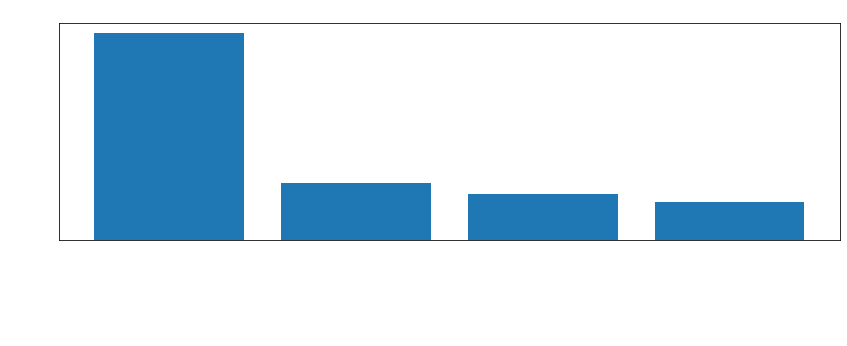

In [62]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 4
rcParams['text.color'] = "white"
rcParams['axes.labelcolor'] = "white"
rcParams['xtick.color'] = "white"
rcParams['ytick.color'] = "white"

index = np.arange(len(labelled_counts.keys()))
plt.bar(index, list(labelled_counts.values()))
plt.xlabel('Defect Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, labelled_counts.keys(), fontsize=5, rotation=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Defect Class Balance')
plt.show()

### Create new directory for training CSVs

In [ ]:
directory(**{
    "choice" : "make",
    "directory_path" : "training_csvs"
})

### Create individual CSV files for each CLASS

In [64]:
image_labels_frame

,Unnamed: 0,name,label
0,2,extract_1158.png,NOT
1,5,extract_866.png,spur
2,6,extract_688.png,spur
3,7,extract_15.png,NOT
4,8,extract_622.png,spur
...,...,...,...
769,1005,extract_704.png,short
770,1006,extract_41.png,NOT
771,1008,extract_1174.png,spurious copper
772,1011,extract_604.png,NOT


In [65]:
'extract_1580.png' in lst

False

In [71]:
image_labels_frame.iterrows()

,Unnamed: 0,name,label
0,2,extract_1158.png,NOT
1,5,extract_866.png,spur
2,6,extract_688.png,spur
3,7,extract_15.png,NOT
4,8,extract_622.png,spur
...,...,...,...
769,1005,extract_704.png,short
770,1006,extract_41.png,NOT
771,1008,extract_1174.png,spurious copper
772,1011,extract_604.png,NOT


In [72]:
spur = []
short = []
spurious = []
not_defect = []
for index, row in image_labels_frame.iterrows():
  if(row[2] == 'spur'):
    spur.append(row[1])
  if(row[2] == 'short'):
    short.append(row[1])
  if(row[2] == 'spurious copper'):
    spurious.append(row[1])
  if(row[2] == 'NOT'):
    not_defect.append(row[1])

In [73]:
df_spur = pd.DataFrame(spur)
df_spur.to_csv("spur.csv", sep=',',index=False)

df_short = pd.DataFrame(short)
df_short.to_csv("short.csv", sep=',',index=False)

df_spurious = pd.DataFrame(spurious)
df_spurious.to_csv("spurious.csv", sep=',',index=False)

df_not_defect = pd.DataFrame(not_defect)
df_not_defect.to_csv("not_defect.csv", sep=',',index=False)

### Create Directories for CSV files (needed for FastAI)

In [ ]:
df_spur

In [75]:
df_spur_new=[]
df_spur.values[0]

array(['extract_866.png'], dtype=object)

In [76]:
for folder in ['short', 'spur', 'spurious', 'not_defect']:
    directory(**{
        "choice" : "make",
        "directory_path" : "training_csvs/" + folder
    })

### Move CSV files to all_extracts directory

In [77]:
move_files(**{
    "file_paths" : ["short.csv", "spur.csv", "spurious.csv", "not_defect.csv"],
    "target_directory" : "training_csvs/"
})

### Remove extracted_defects.zip and upload the extracted_defects.zip used for labelling with the Defect Turker (while these may often be the same file, if you restarted this pipeline this will not be the case. Uploading is the safest).

In [32]:
!rm extracted_defects.zip

In [ ]:
# upload extracted_defects.zip used for Defect Turker
files.upload()

### Move extracted_defects.zip into the training_csvs folder:

In [78]:
move_files(**{
    "file_paths" : ["extracted_defects.zip"],
    "target_directory" : "training_csvs"
})

### Extract all images from extracted_defects.zip into the training_csvs folder:

In [79]:
import zipfile
with zipfile.ZipFile("training_csvs/extracted_defects.zip", 'r') as zip_ref:
    zip_ref.extractall("training_csvs/")

### Move all extracted defect images into their proper training folder, using the image_labels.csv data:

In [37]:
l=os.listdir("/content/all_extracts")
"extract_1580.png" in l

False

In [62]:
os.listdir("/content/training_csvs/not_defect")

[]

In [80]:
path = "training_csvs/"
path_to_extracts = "training_csvs/content/all_extracts/"

for index, row in df_spur.iterrows():    
      from_path = path_to_extracts + row[0]
      to_path = path + "spur/" + row[0]     
      move_files(**{
          "file_paths" : [from_path],
          "target_directory" : to_path
      })
    
for index, row in df_short.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "short/" + row[0]     
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

for index, row in df_spurious.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "spurious/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

for index, row in df_not_defect.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/not_defect/" + row[0]     
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

In [61]:
path = "training_csvs/"
path_to_extracts = "training_csvs/content/all_extracts/"

for index, row in df_spur.iterrows():    
      from_path = path_to_extracts + row[0]
      to_path = path + "spur/" + row[0]     
      move_files(**{
          "file_paths" : [from_path],
          "target_directory" : to_path
      })
    
for index, row in df_short.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "short/" + row[0]     
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

for index, row in df_spurious.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "spurious/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

for index, row in df_not_defect.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/not_defect/" + row[0]     
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

FileNotFoundError: ignored

### Remove any remaining PNG files (defect images) that were not labelled:

In [81]:
directory(**{
    "choice" : "remove",
    "directory_path" : "training_csvs/content",
    "force" : True
})

### Read in image data

In [82]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4, bs=10).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

### Inspect Images to Confirm Read Properly

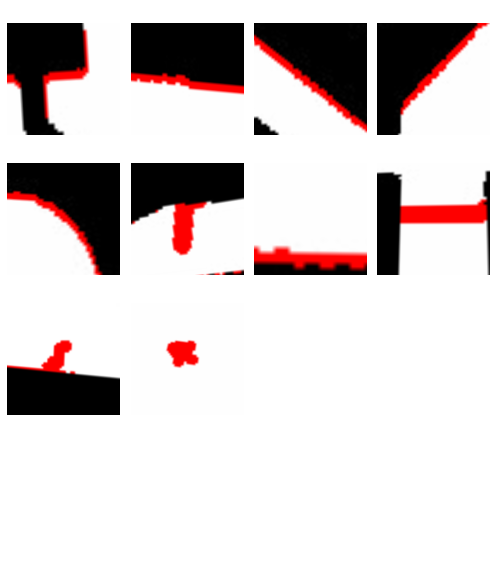

In [83]:
data.show_batch(rows=4, figsize=(7, 8))

### Train Model

In [85]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Use fit_one_cycle to change the learning rate over time (use GPU)

In [ ]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.309126,1.787686,0.681818,03:31
1,2.126094,1.880053,0.610390,03:25
2,1.986031,1.935516,0.538961,03:25
3,1.805330,1.673372,0.545455,03:24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Find better learning rates using lr_find, and use recorder.plot to create a plot that relates the learning rate with the loss.

In [ ]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


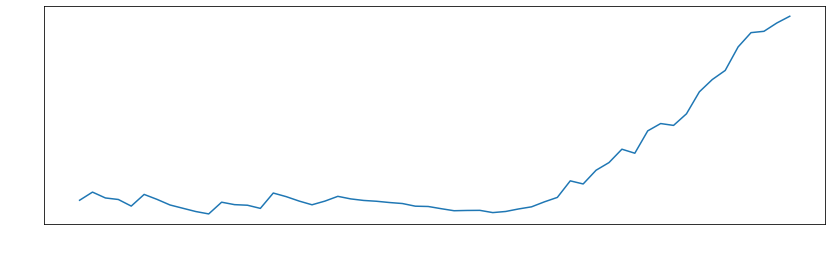

In [ ]:
learn.recorder.plot()

### Train the model using differential learning rates by passing the max_lr argument to the fit_one_cycle method.

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.184295,0.126775,0.039427,09:12
1,0.276375,0.147388,0.046595,09:12
2,0.160508,0.054374,0.010753,09:10
3,0.087525,0.052762,0.014337,08:51


### SAVE the model for inference

In [ ]:
learn.save('defect_classifier')

### Export Model

In [ ]:
learn.load('defect_classifier')
learn.export('defect_classifier.pkl')

### Examine Confusion Matrix

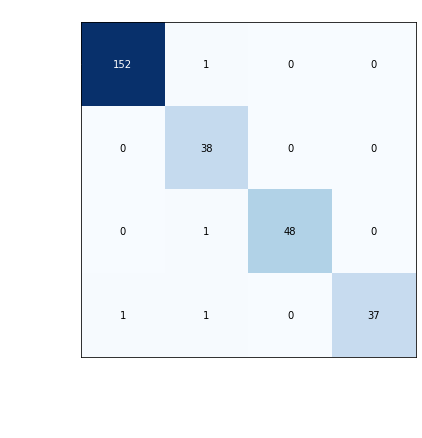

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

### Create JSON file with new boards filenames

In [ ]:
test_temps = {}
file_names = os.listdir('hold_out')

for index, file in enumerate(file_names):
  if "test" in file:
      test_temps[file_names[index]] = os.path.getsize('hold_out/' + file)

In [ ]:
with open('test_temps.json', 'w') as outfile:
    json.dump(test_temps, outfile)

### Download hold out images to use with PCB Defect Classifier

In [ ]:
# remove any files that are not JPG
!find hold_out -type f ! -name '*.jpg' -delete

zip_files_in_directory(**{
    "directory" : "hold_out/",
    "zip_filename" : "hold_out.zip"
})